#### Data Set Information:

This dataset contains the motion data of 14 healthy older aged between 66 and 86 years old, performed broadly scripted activities using a batteryless, wearable sensor on top of their clothing at sternum level. Data is sparse and noisy due to the use of a passive sensor.
Participants were allocated in two clinical room settings (S1 and S2). The setting of S1 (Room1) uses 4 RFID reader antennas around the room (one on ceiling level, and 3 on wall level) for the collection of data, whereas the room setting S2 (Room2) uses 3 RFID reader antennas (two at ceiling level and one at wall level) for the collection of motion data.
The activities performed were:
- walking to the chair,
- sitting on the chair,
- getting off the chair,
- walking to bed,
- lying on bed,
- getting off the bed and
- walking to the door.
 ###### Hence the possible class labels assigned for every sensor observation are:
- Sitting on bed
- Sitting on chair
- Lying on bed
- Ambulating, where ambulating includes standing, walking around the room.


#### Attribute Information:

The content of the file is as follows:
Comma separated values (CSV) format.
- Time in seconds
- Acceleration reading in G for frontal axis
- Acceleration reading in G for vertical axis
- Acceleration reading in G for lateral axis
- Id of antenna reading sensor
- Received signal strength indicator (RSSI)
- Phase
- Frequency
- Label of activity, 1: sit on bed, 2: sit on chair, 3: lying, 4: ambulating




In [4]:
import os
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import preprocessing
import seaborn as sns
import random
from collections import Counter
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier
import wittgenstein as lw
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from mlxtend.plotting import plot_decision_regions


from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings('ignore')

# Explore S1 First

In [5]:
S1PATH = os.path.join('..','..','C:/Users/Mahran/Desktop/Year 3/Machine Learning/ML-Assignment1','S1_Dataset')
s1 = pd.DataFrame()
for filename in os.listdir(S1PATH):
    if filename != 'README.txt':
        data_path = os.path.join(S1PATH, filename)
        data=pd.read_csv(data_path, header=None)
        s1= s1.append(data, ignore_index=True)
s1.columns = ['time','frontal','vertical','lateral','id','rssi','phase','frequency','activity']
s1.head()

,time,frontal,vertical,lateral,id,rssi,phase,frequency,activity
0,0.00,0.27203,1.00820,-0.082102,1,-63.5,2.4252,924.25,1
1,0.50,0.27203,1.00820,-0.082102,1,-63.0,4.7369,921.75,1
2,1.50,0.44791,0.91636,-0.013684,1,-63.5,3.0311,923.75,1
3,1.75,0.44791,0.91636,-0.013684,1,-63.0,2.0371,921.25,1
4,2.50,0.34238,0.96229,-0.059296,1,-63.5,5.8920,920.25,1


In [6]:
s1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52482 entries, 0 to 52481
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       52482 non-null  float64
 1   frontal    52482 non-null  float64
 2   vertical   52482 non-null  float64
 3   lateral    52482 non-null  float64
 4   id         52482 non-null  int64  
 5   rssi       52482 non-null  float64
 6   phase      52482 non-null  float64
 7   frequency  52482 non-null  float64
 8   activity   52482 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 3.6 MB


In [7]:
s1.shape

(52482, 9)

In [8]:
s1.isna().sum()

time         0
frontal      0
vertical     0
lateral      0
id           0
rssi         0
phase        0
frequency    0
activity     0
dtype: int64

In [9]:
unique, counts = np.unique(s1['activity'], return_counts=True)
CountOfClasses=dict(zip(unique, counts))
CountOfClasses

{1: 15162, 2: 4381, 3: 30983, 4: 1956}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


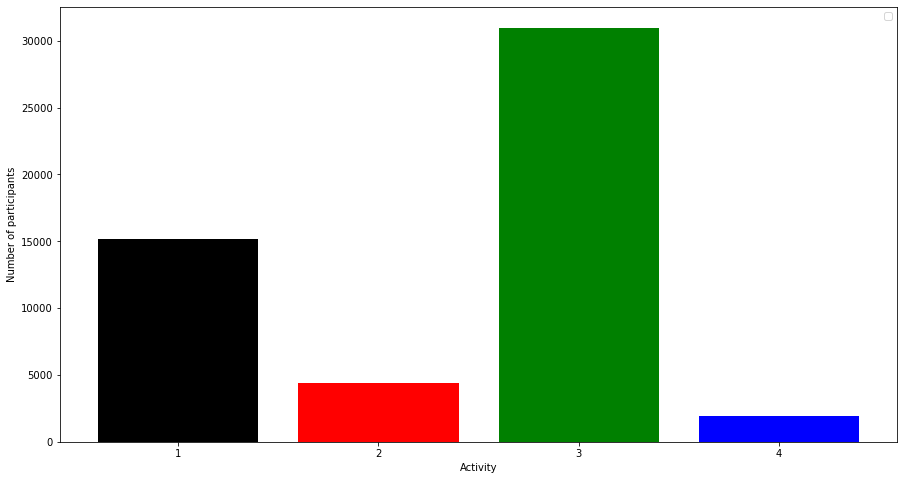

In [10]:
fig = plt.figure(figsize = (15.0,8.0))
ax= fig.add_subplot(111)
plt.bar(*zip(*CountOfClasses.items()),color=['black', 'red', 'green', 'blue'])
plt.xticks([1,2,3,4])
plt.legend()
plt.ylabel("Number of participants")
plt.xlabel("Activity")
plt.show()

# Explore S2 too

In [11]:
S2PATH = os.path.join('..','..','C:/Users/Mahran/Desktop/Year 3/Machine Learning/ML-Assignment1','S2_Dataset')
s2 = pd.DataFrame()
for filename in os.listdir(S2PATH):
    if filename != 'README.txt':
        data_path = os.path.join(S2PATH, filename)
        data=pd.read_csv(data_path, header=None)
        s2= s2.append(data, ignore_index=True)
s2.columns = ['time','frontal','vertical','lateral','id','rssi','phase','frequency','activity']
s2.head()

,time,frontal,vertical,lateral,id,rssi,phase,frequency,activity
0,0.00,-0.232160,0.215880,-1.18820,2,-48.5,2.74430,920.75,3
1,0.25,-0.056282,0.043636,-1.14260,2,-50.0,2.36540,921.75,3
2,0.50,0.143050,0.296270,-1.33640,3,-59.5,0.20709,922.25,3
3,0.75,0.318930,0.284780,-0.92593,2,-51.0,0.41571,923.25,3
4,1.05,0.412730,0.135500,-1.02860,2,-44.5,4.45470,920.25,3


In [12]:
s2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22646 entries, 0 to 22645
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       22646 non-null  float64
 1   frontal    22646 non-null  float64
 2   vertical   22646 non-null  float64
 3   lateral    22646 non-null  float64
 4   id         22646 non-null  int64  
 5   rssi       22646 non-null  float64
 6   phase      22646 non-null  float64
 7   frequency  22646 non-null  float64
 8   activity   22646 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 1.6 MB


In [13]:
s2.shape

(22646, 9)

In [14]:
s2.isna().sum()

time         0
frontal      0
vertical     0
lateral      0
id           0
rssi         0
phase        0
frequency    0
activity     0
dtype: int64

In [15]:
unique, counts = np.unique(s2['activity'], return_counts=True)
CountOfClasses=dict(zip(unique, counts))
CountOfClasses

{1: 1244, 2: 530, 3: 20537, 4: 335}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


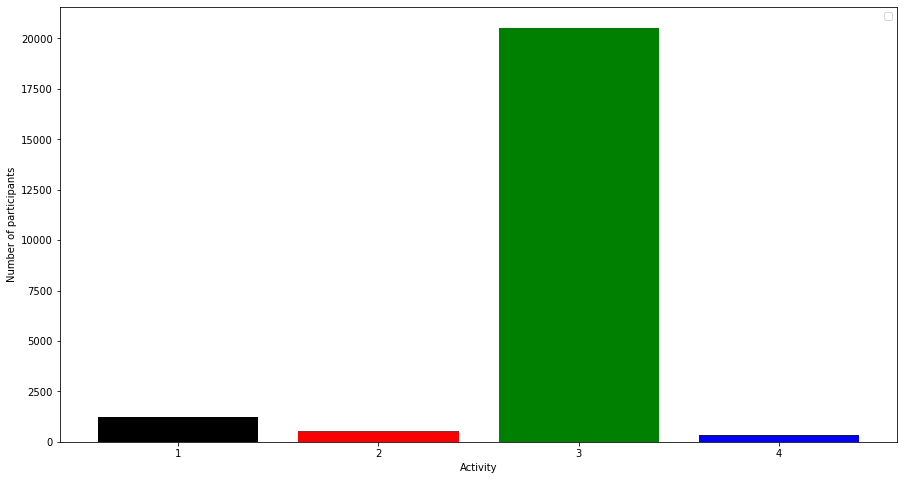

In [16]:
fig = plt.figure(figsize = (15.0,8.0))
ax= fig.add_subplot(111)
plt.bar(*zip(*CountOfClasses.items()),color=['black', 'red', 'green', 'blue'])
plt.xticks([1,2,3,4])
plt.legend()
plt.ylabel("Number of participants")
plt.xlabel("Activity")
plt.show()

# We will stick with S1 as it has less imbalance than S2

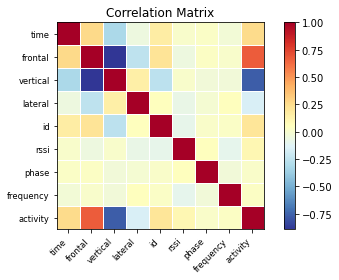

In [17]:
correlarion= s1.corr()
sm.graphics.plot_corr(correlarion, xnames=list(correlarion.columns))
plt.show()

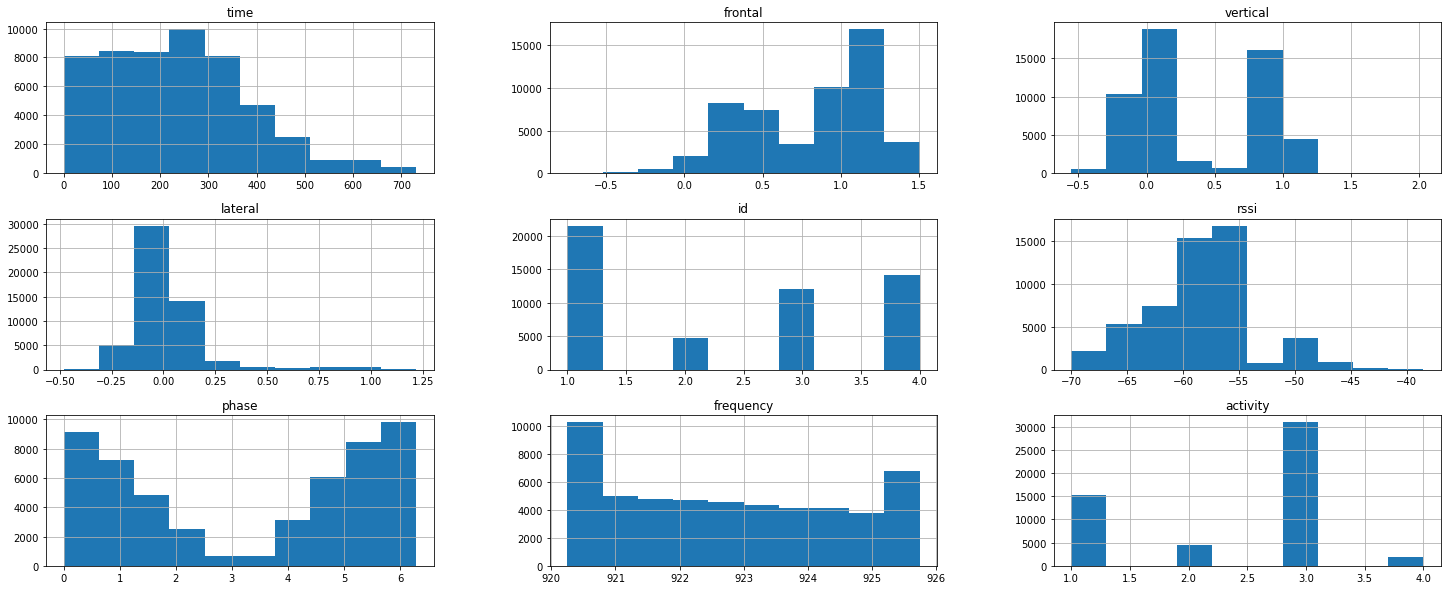

In [26]:
s1.hist(figsize=(25, 10))
plt.show()

In [30]:
s1[s1['lateral'] > 0.50].value_counts().sum()

1504

{'whiskers': [<matplotlib.lines.Line2D at 0x1f7c7c2f4f0>,
 'caps': [<matplotlib.lines.Line2D at 0x1f7c7c2f8e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f7c7a38fa0>],
 'medians': [<matplotlib.lines.Line2D at 0x1f7c7c2f100>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f7c7c02640>],
 'means': []}

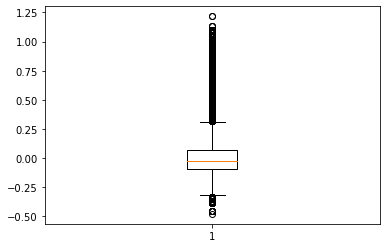

In [38]:
plt.boxplot(s1['lateral'])

In [31]:
s1[s1['frontal'] < 0.0].value_counts().sum()

1041

{'whiskers': [<matplotlib.lines.Line2D at 0x1f7c8243310>,
 'caps': [<matplotlib.lines.Line2D at 0x1f7c82438b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f7c82431c0>],
 'medians': [<matplotlib.lines.Line2D at 0x1f7c8243e50>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f7c825f160>],
 'means': []}

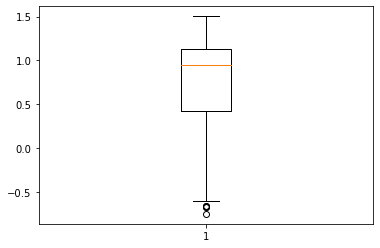

In [34]:
plt.boxplot(s1['frontal'])

In [32]:
s1[s1['vertical'] < -0.1].value_counts().sum()

5851

{'whiskers': [<matplotlib.lines.Line2D at 0x1f7c9b8f7c0>,
 'caps': [<matplotlib.lines.Line2D at 0x1f7c9b8fd60>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f7c9b8f610>],
 'medians': [<matplotlib.lines.Line2D at 0x1f7c9bb3340>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f7c9bb3610>],
 'means': []}

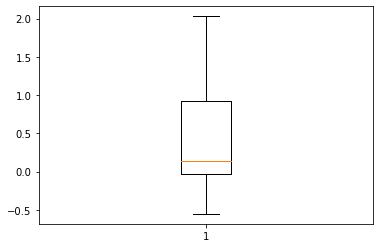

In [35]:
plt.boxplot(s1['vertical'])

# These are not considered as outliers , as it is the nature of a sensor that captures the movement . the movement is translated on a 3-dimensional cartesian plane X,Y,Z

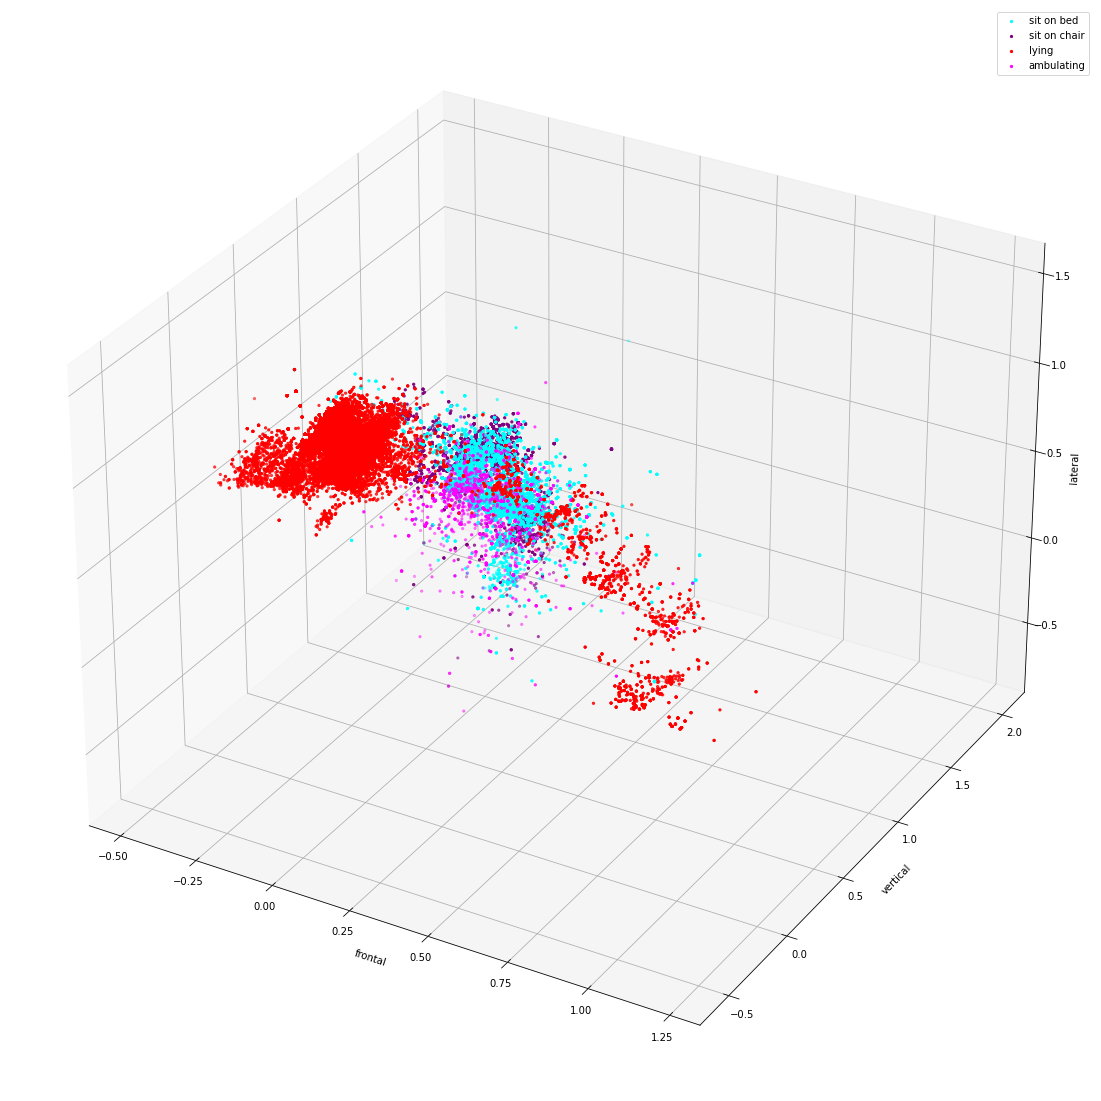

In [97]:
fig = plt.figure(figsize = (20.0,20.0))
ax= fig.add_subplot(111,projection ='3d')

cond = [(1,'#00FFFF', 'sit on bed'),(2,'#800080','sit on chair'),(3,'#FF0000', 'lying'),(4,'#FF00FF', 'ambulating')]

for x,color,action in cond:
    xs = s1.loc[s1["activity"] == x]['lateral']
    ys = s1.loc[s1['activity'] == x]['vertical']
    zs = s1.loc[s1['activity'] == x]['frontal']
    ax.scatter(xs, ys, zs, c=color, marker='.', label=action)

ax.legend()
ax.set_xlabel('frontal')
ax.set_ylabel('vertical')
ax.set_zlabel('lateral')


plt.show()

# the plot above shows which type of movement is capured for each activity 

# Split the dataset for training

In [253]:
x = s1.iloc[:,:8]
y = s1.iloc[:,8:9]

In [254]:
x

,time,frontal,vertical,lateral,id,rssi,phase,frequency
0,0.00,0.272030,1.00820,-0.082102,1,-63.5,2.4252,924.25
1,0.50,0.272030,1.00820,-0.082102,1,-63.0,4.7369,921.75
2,1.50,0.447910,0.91636,-0.013684,1,-63.5,3.0311,923.75
3,1.75,0.447910,0.91636,-0.013684,1,-63.0,2.0371,921.25
4,2.50,0.342380,0.96229,-0.059296,1,-63.5,5.8920,920.25
...,...,...,...,...,...,...,...,...
52477,485.00,0.330660,0.95081,-0.230340,1,-57.0,6.2188,921.75
52478,485.08,0.330660,0.95081,-0.230340,3,-58.0,0.8805,921.75
52479,485.50,0.330660,0.95081,-0.230340,1,-60.5,5.0054,924.75
52480,488.25,0.119600,0.82449,0.009122,4,-56.0,4.9087,925.75


# Modelling

## We will try 3 different models
- Descion tree classifier 
- Logistic Regression
- K-nearest neighbor

###### For simplicity , we will code a helper function for the modeling of the 3 models , and another function for the learning curve

In [313]:
def plot_LC(estimator , x,y, scoring):
    train_sizes, train_scores, test_scores = learning_curve(
    estimator=estimator,
    X=x,
    y=y,
    cv=5,
    scoring=scoring,
    train_sizes = [0.2,0.4,0.6,0.8,1]
    )
    
    if scoring == 'accuracy':
        
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)

        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        plt.subplots(1, figsize=(8,8))
        plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
        plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

        plt.title("Learning Curve")
        plt.xlabel("Training Set Size"), plt.ylabel(scoring+" Score"), plt.legend(loc="best")
        plt.tight_layout()
        plt.show()
        
    elif scoring == 'neg_root_mean_squared_error':
        train_mean = -train_scores.mean(axis=1)
        train_std = -train_scores.std(axis=1)

        test_mean = -test_scores.mean(axis=1)
        test_std = -test_scores.std (axis=1)

        plt.subplots(figsize=(8,8))
        plt.plot(train_sizes, train_mean, label="train")
        plt.plot(train_sizes, test_mean, label="validation")

        plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r")
        plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

        plt.title("Learning Curve")
        plt.xlabel("Training Set Size")
        plt.ylabel("Error")
        plt.legend(loc="best")

        plt.show()

In [306]:
def modelfit(x,y,X_train, X_test, y_train, y_test,model,strat):
    if model == 'DT':
        for i in range (2 , 11):

            treecf = DecisionTreeClassifier(max_depth=i,class_weight='balanced') #used 'balanced' because not all classes have the same weight

            treecf.fit(X_train,y_train)

            y_pred = treecf.predict(X_test)
    
            acc_train = treecf.score(X_train,y_train)
            acc_test = treecf.score(X_test, y_test)
            print("max_depth:{}".format(i))
            print("Traing accuracy:{:.3f}".format(acc_train),"\nTesting accuracy:{}".format(acc_test))
            print("---------------------------")
        acc_train = treecf.score(X_train,y_train)
        acc_test = treecf.score(X_test, y_test)
        print("Traing accuracy:{:.3f}".format(acc_train),"\nTesting accuracy:{}".format(acc_test))
        print("=========================Classification_report for DT================================")
        classf = classification_report(y_test, y_pred, target_names=['1','2','3','4'] )
        print(classf)
        plot_confusion_matrix(treecf, X_train,y_train)  
        plt.title('Confussion Matrix for DT')
        plt.show()
        plot_LC(treecf , x,y, 'neg_root_mean_squared_error')
        
    if model == 'KNN':
        k_range = range(1, 10)
        scores = []
        for k in k_range:
            knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            scores.append(metrics.accuracy_score(y_test, y_pred))
        plt.plot(k_range, scores)
        plt.xlabel('Value of K for KNN')
        plt.ylabel('Testing Accuracy')
        
    if model == "LG":
        training_accuracy = []
        test_accuracy=[]
        Cs=np.arange(0.001,5,0.5)
        for c in Cs:
            logisticregression = LogisticRegression(C=c,max_iter=100 ,multi_class=strat,class_weight='balanced').fit(X_train, y_train)
            training_accuracy.append(logisticregression.score(X_train,y_train))
            test_accuracy.append(logisticregression.score(X_test,y_test))
        plt.plot(Cs, training_accuracy, label="training accuracy")
        plt.plot(Cs, test_accuracy, label="test accuracy")
        plt.legend()

# the models will be tested before feature selection and after feature selection 

#  Desicion Tree Before feature selection



max_depth:2
Traing accuracy:0.894 
Testing accuracy:0.8977278140332492
---------------------------
max_depth:3
Traing accuracy:0.865 
Testing accuracy:0.8638117467727338
---------------------------
max_depth:4
Traing accuracy:0.977 
Testing accuracy:0.9752298385176011
---------------------------
max_depth:5
Traing accuracy:0.966 
Testing accuracy:0.9661792025913399
---------------------------
max_depth:6
Traing accuracy:0.974 
Testing accuracy:0.9710379650359644
---------------------------
max_depth:7
Traing accuracy:0.966 
Testing accuracy:0.9618920592578478
---------------------------
max_depth:8
Traing accuracy:0.981 
Testing accuracy:0.9760872671842995
---------------------------
max_depth:9
Traing accuracy:0.984 
Testing accuracy:0.9785642833325394
---------------------------
max_depth:10
Traing accuracy:0.986 
Testing accuracy:0.9791359024436717
---------------------------
Traing accuracy:0.986 
Testing accuracy:0.9791359024436717
=========================Classification_report fo

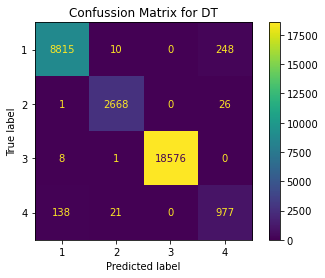

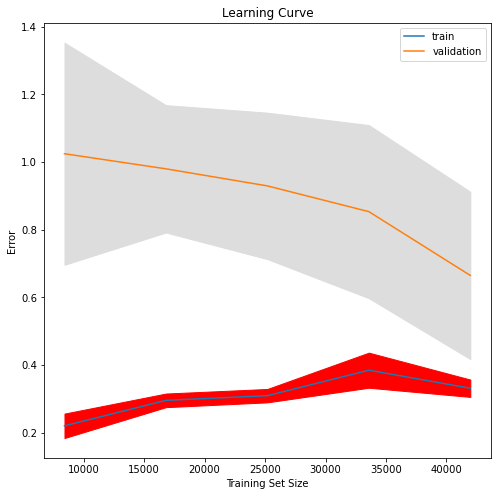

In [314]:
X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.4, random_state=42)
modelfit(x,y,X_train, X_test, y_train, y_test,'DT',strat=None)

# Ideal max depth is 6 after that it starts overfitting


# Now we will test KNN

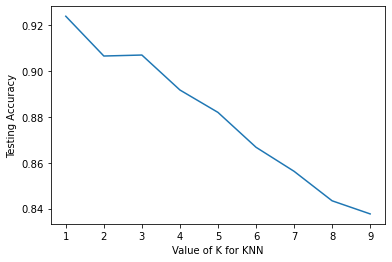

In [288]:
X_train, X_test, y_train, y_test = train_test_split(x, y,stratify=y,test_size=0.4, random_state=42)
modelfit(x,y,X_train, X_test, y_train, y_test,'KNN',strat=None)

# Ideal K is 1

### now for logistic regression

# We will test multinomial first 

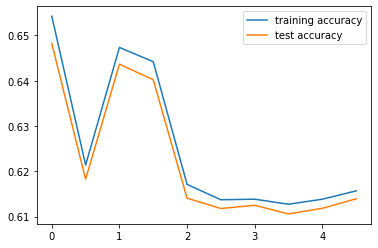

In [307]:
X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.4, random_state=42)
modelfit(x,y,X_train, X_test, y_train, y_test,'LG',strat = 'multinomial')

# Ideal C is 1

# One VS Rest (OVR)

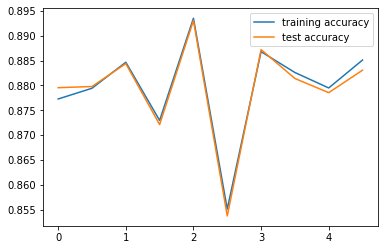

In [308]:
X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.4, random_state=42)
modelfit(x,y,X_train, X_test, y_train, y_test,'LG',strat = 'ovr')

# Ideal C is 2

# 3) Exhaustive Feature Selection (EFS) as a feature selection method since variance would remove needed features due to the nature of the features

In [264]:
X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.4, random_state=42)

In [268]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
efs = EFS(KNeighborsClassifier(n_neighbors=4),
         min_features= 4,
          max_features= 6,
          scoring='accuracy',
          cv = None,
          n_jobs=-1
         ).fit(X_train, y_train)

Features: 154/154

In [269]:
df = pd.DataFrame.from_dict(efs.get_metric_dict()).T
df = df[["feature_idx","avg_score"]]
df

,feature_idx,avg_score
0,"(0, 1, 2, 3)",0.948966
1,"(0, 1, 2, 4)",0.977865
2,"(0, 1, 2, 5)",0.942075
3,"(0, 1, 2, 6)",0.942011
4,"(0, 1, 2, 7)",0.940392
...,...,...
149,"(1, 2, 3, 4, 6, 7)",0.980533
150,"(1, 2, 3, 5, 6, 7)",0.960431
151,"(1, 2, 4, 5, 6, 7)",0.985963
152,"(1, 3, 4, 5, 6, 7)",0.976659


In [270]:
efs.best_score_

0.9894248785290102

In [271]:
efs.best_feature_names_

('frontal', 'vertical', 'lateral', 'id', 'rssi')

In [272]:
efs.best_idx_

(1, 2, 3, 4, 5)

In [278]:
X_train.iloc[:,1:6]

,frontal,vertical,lateral,id,rssi
21656,1.374200,-0.117130,-0.025087,3,-61.0
46028,0.447910,0.927840,-0.002281,1,-56.5
12531,-0.079733,0.950810,0.123150,1,-59.0
10152,0.342380,0.881910,0.362620,1,-59.5
45605,0.436190,0.927840,-0.036490,4,-57.0
...,...,...,...,...,...
11284,0.940380,-0.036746,-0.013684,3,-50.5
44732,1.139700,0.020670,-0.070699,4,-62.0
38158,0.342380,0.973770,-0.059296,1,-57.0
860,1.081100,-0.231960,-0.196130,1,-66.5


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Number of Features', ylabel='Performance'>)

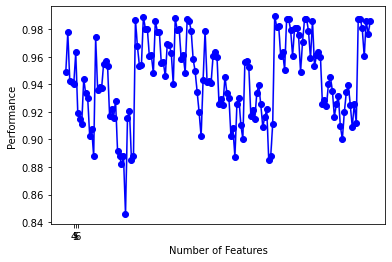

In [164]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

plot_sfs(efs.get_metric_dict(), kind='std_dev')

# Modeling after feature selection

# DT after feature selection

max_depth:2
Traing accuracy:0.894 
Testing accuracy:0.8977278140332492
---------------------------
max_depth:3
Traing accuracy:0.865 
Testing accuracy:0.8635735721430953
---------------------------
max_depth:4
Traing accuracy:0.977 
Testing accuracy:0.9752298385176011
---------------------------
max_depth:5
Traing accuracy:0.967 
Testing accuracy:0.9672271709617491
---------------------------
max_depth:6
Traing accuracy:0.978 
Testing accuracy:0.9755632829990949
---------------------------
max_depth:7
Traing accuracy:0.959 
Testing accuracy:0.9575096460725003
---------------------------
max_depth:8
Traing accuracy:0.963 
Testing accuracy:0.9580336302577049
---------------------------
max_depth:9
Traing accuracy:0.973 
Testing accuracy:0.9667031867765445
---------------------------
max_depth:10
Traing accuracy:0.980 
Testing accuracy:0.9731339017767827
---------------------------
Traing accuracy:0.980 
Testing accuracy:0.9731339017767827
=========================Classification_report fo

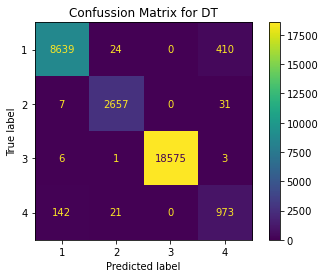

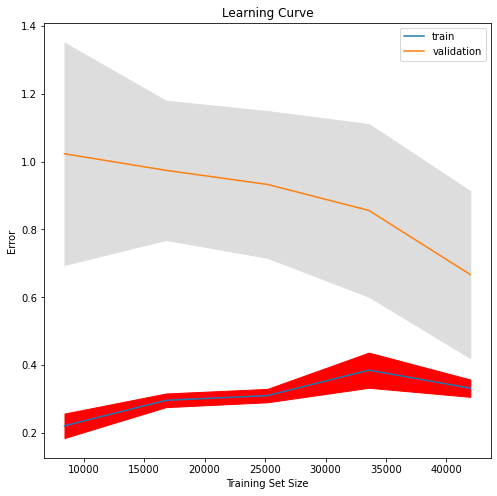

In [315]:
X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.4, random_state=42)
X_train=X_train.iloc[:,1:6]
X_test=X_test.iloc[:,1:6]
modelfit(x,y,X_train, X_test, y_train, y_test,'DT',strat=None)

# Better after feature selection

# KNN After feature selection

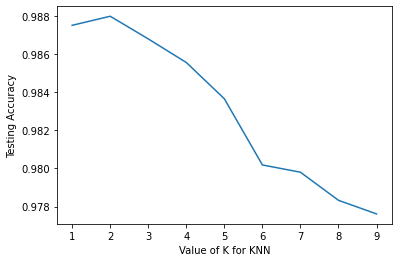

In [292]:
X_train, X_test, y_train, y_test = train_test_split(x, y,stratify=y,test_size=0.4, random_state=42)
X_train=X_train.iloc[:,1:6]
X_test=X_test.iloc[:,1:6]
modelfit(x,y,X_train, X_test, y_train, y_test,'KNN',strat=None)

# Best K is 2 and better than previous KNN

# Logistic Regression After feature selection

# OVR

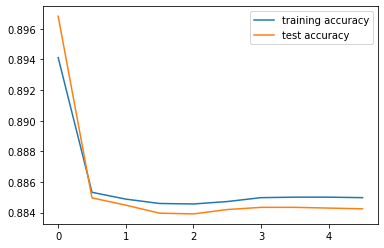

In [309]:
X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.4, random_state=42)
X_train=X_train.iloc[:,1:6]
X_test=X_test.iloc[:,1:6]
modelfit(x,y,X_train, X_test, y_train, y_test,'LG',strat='ovr')

# Ideal C is 0.001

# MultiNomial

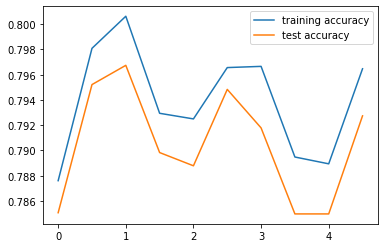

In [310]:
X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.4, random_state=42)
X_train=X_train.iloc[:,1:6]
X_test=X_test.iloc[:,1:6]
modelfit(x,y,X_train, X_test, y_train, y_test,'LG',strat="multinomial")

# Ideal C is 0.5

# Side by Side Comparison for each model for the best results

                
                     DT Before Feature Selection
                precision  recall   f1-score   support

           1       0.98      0.96      0.97      6089                                
           2       0.98      0.98      0.98      1686
           3       1.00      1.00      1.00     12398
           4       0.72      0.80      0.76       820

    accuracy                            0.98     20993
    macro avg       0.92      0.94      0.93     20993
    weighted avg    0.98      0.98      0.98     20993
   
     ============================================================
                       DT After Feature Selection
                             
               precision    recall  f1-score   support

           1       0.98      0.94      0.96      6089
           2       0.97      0.98      0.98      1686
           3       1.00      1.00      1.00     12398
           4       0.64      0.81      0.71       820

    accuracy                            0.97     20993
    macro avg       0.90      0.93      0.91     20993
    weighted avg    0.98      0.97      0.97     20993

# DT Before
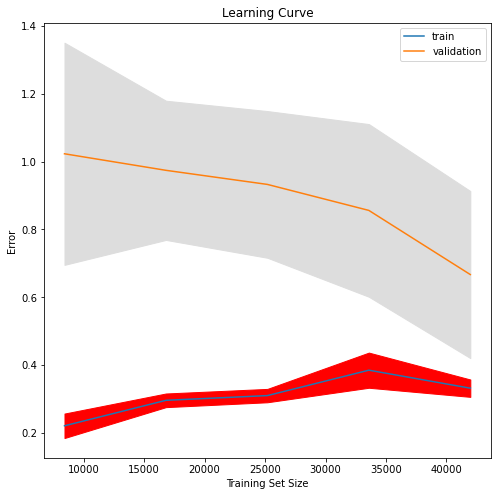
# DT After
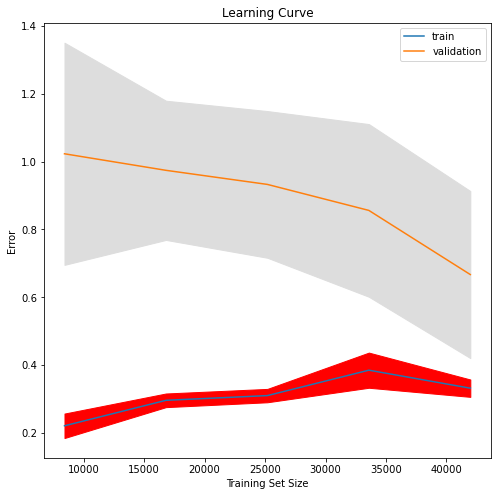

# KNN Before Feature Selection 
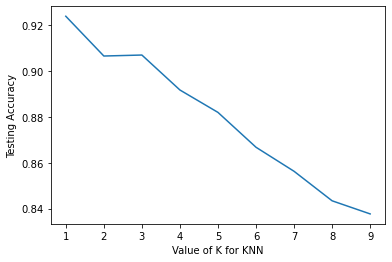
# KNN After Feature Selection
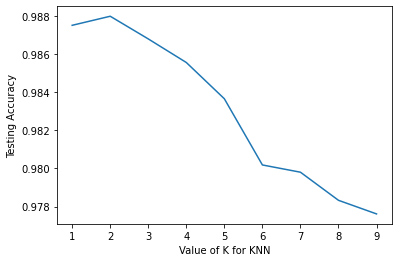

# LG MultiNomial Before
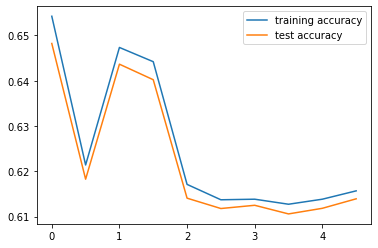

# LG MultiNomial After
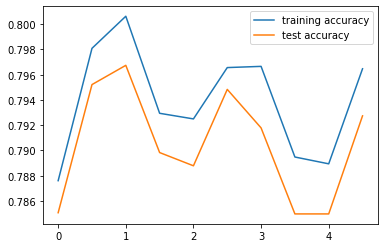

# LG OVR Before
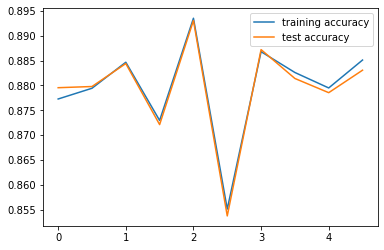
# LG OVR After
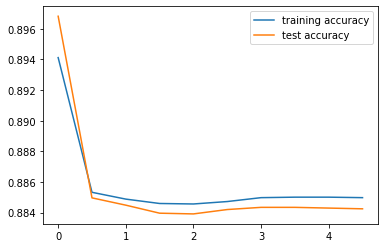

Decision Tree obtained slightly better readings after feature selection in terms of precision but got worse for some classes in the recall .
for the f1-score , feature selection had no positive impact.
as for the learning curve , there were no big difference.
Logistic regression when using Multinomial strategy yeilded a better training accuracy after feature selection but also not that quite good accuracy due to the data's imbalance
when using OVR strategy , the feature selection downgraded the performance.
KNN was the most positivly affected model out of the previous 2 , as its accuracy for the best K before feature selection was 93% for the best K = 1, where after feature selection it had an accuracy of 98% for the K =2 

Lastly , the data could have made the models perform better if it was balanced and  not sparse and noisy due to the use of a passive sensor.